In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve, ConfusionMatrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import category_encoders as ce


## Summery
1. Reading the files
2. Considerations
3. Modeling
4. Future works
#


#### 1. Reading the files

In [4]:
SEED = 42

In [5]:
df = pd.read_csv('../data/data_fe.csv')
labels = pd.read_csv('../data/machine_learning_challenge_labeled_data.csv')

data = df.merge(labels, on='customer_id')
data.shape

(245455, 70)

#### 2. Considerations
* `Metric`: As we saw, the data is an imbalance, so picking the metric should be less sensitive to this part(EX. AUC is not the best metric because of that). In the good practical setup, we could use a **cost function** for confusion matrix(EX. what is the cost of losing someone by not detecting them(FP), or what is the cost of sending a voucher to someone is not going to be churn(FN)), But here we don't have that information, we need a metric another metric to look at. Another point is we need to have only one metric to compare things. It's nice to be able to compare models in different ways, but we need to pick one metric. Between **F1** and **average precision**, I chose **average precision** because at the same time we can use precision-recall plots as well.
* `Cross-validation`: I split the data into train-test(0.8-0.2) with keeping the ratio of the rare class in both sides. I don't have enough computation power to do k-fold validation, But it's something good to try.
* `Categorical Features`: Encoding categorical features can be tricky and it depends on the model. For example Tree based models are not good in handleing the OneHot encoding but Linear models are like it more, On the other hand binnery encoding could be a good option for trees. One other way is to replace the feature with it counts. We may lose some infromation becasue of encoding, but it's we have to test and see which works better.
* `reproducibility`: I'm using SEED in all of the random part of models, to make them reproducibile.

### 3.Modeling

In [6]:
# target = data.is_returning_customer

In [7]:
cats = ['last_restaurant','last_city', 'last_order_payment_id', 'last_order_platform_id', 'last_order_transmission_id']

In [8]:
data[cats] = data[cats].astype('str')

In [9]:
data.isna().any()[data.isna().any() == True]

voucher_amount_std    True
delivery_fee_std      True
amount_paid_std       True
dtype: bool

In [10]:
data.fillna(-1,inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['customer_id', 'is_returning_customer'], axis=1),
    data.is_returning_customer,
    train_size = 0.8, shuffle= SEED, stratify=labels.is_returning_customer)


#### 3.01- UDF

In [12]:
def data_values(data): return (d.values for d in data)
def lc_plot(model, data, sizes=np.linspace(0.3, 1.0, 4), cv=StratifiedKFold(n_splits=4),  n_jobs=1):
    if type(model) == XGBClassifier : data= data_values(data)
    X_train, y_train, _, _ = data
    visualizer = LearningCurve(
        model, cv=cv, scoring='average_precision', train_sizes=sizes, n_jobs= n_jobs)
    visualizer.fit(X_train, y_train)
    visualizer.show()  
    
def pr_plot(model, data):
    if type(model) == XGBClassifier : data= data_values(data)
    X_train, y_train, X_test, y_test = data
    viz = PrecisionRecallCurve(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
def cm_plot(model, data):
    if type(model) == XGBClassifier : data= data_values(data)
    X_train, y_train, X_test, y_test = data
    cm = ConfusionMatrix(model, classes=[0,1])
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()

#### 3.1- Logistic Regression

In [25]:
# I could use the drop flag, but since I will use l1 penalty, it rally dosnt matter
# standard scaller of faster convergence
ss = StandardScaler()
lr_X_train = ss.fit_transform(X_train.drop(cats, axis=1))
lr_X_test = ss.transform(X_test.drop(cats, axis=1))

lr_data = (lr_X_train, y_train, lr_X_test, y_test)


/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


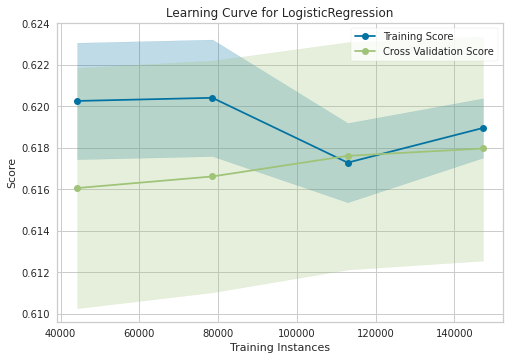

CPU times: user 47.8 s, sys: 22.2 s, total: 1min 10s
Wall time: 40.5 s


In [39]:
%%time
model = LogisticRegression(class_weight='balanced', max_iter=300, random_state=SEED)


lc_plot(model, lr_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


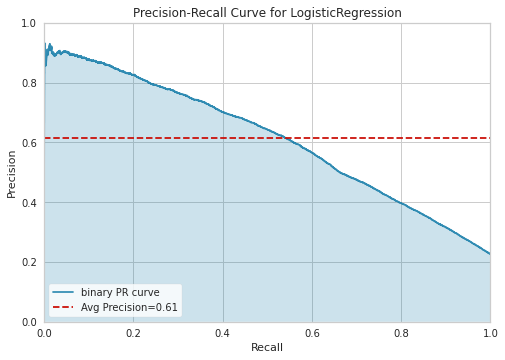

In [44]:
pr_plot(model, lr_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


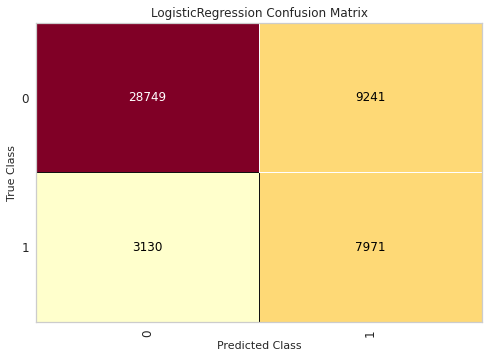

In [41]:
cm_plot(model, lr_data)

From these 2 plots, we can see by increasing the data, the validation score is getting better, therefore So more data could help. The Variance of prediction in 4fold is not that high, so to improve we could add more features or use a more complex model.

#### 3.2- RF

In [11]:
rf_model = RandomForestClassifier(random_state=SEED)

rf_data = (X_train.drop(cats, axis=1), y_train, X_test.drop(cats, axis=1), y_test)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


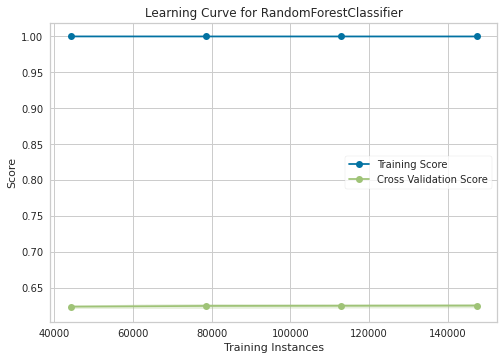

CPU times: user 630 ms, sys: 420 ms, total: 1.05 s
Wall time: 5min 36s


In [14]:
%%time
lc_plot(rf_model, rf_data, n_jobs=2)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


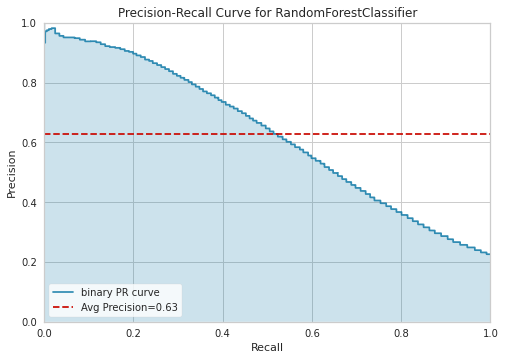

In [15]:
pr_plot(rf_model, rf_data)

its overfitted. Let's try to add some regularization to model and retrain it. 

In [16]:
rf_model = RandomForestClassifier(random_state=SEED, max_depth=15, min_samples_leaf=6)


/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


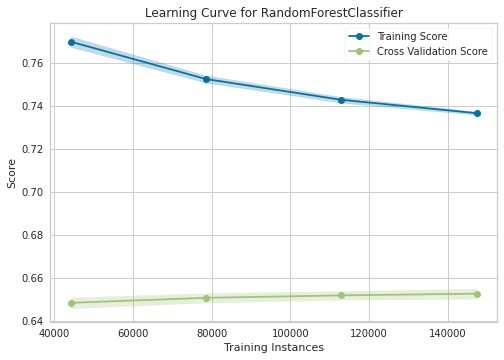

CPU times: user 580 ms, sys: 400 ms, total: 980 ms
Wall time: 4min 51s


In [17]:
%%time
lc_plot(rf_model, rf_data, n_jobs=2)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


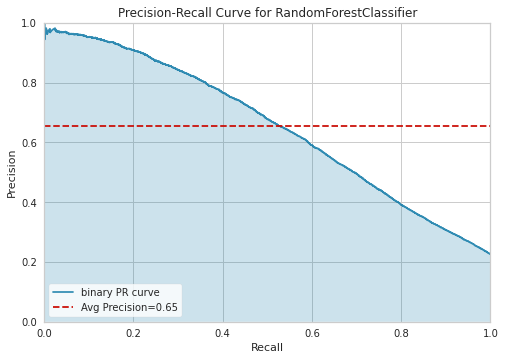

In [18]:
pr_plot(rf_model, rf_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


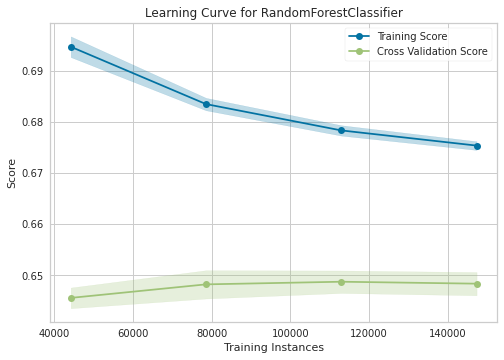

CPU times: user 580 ms, sys: 180 ms, total: 760 ms
Wall time: 3min 5s


In [20]:
%%time
rf_model = RandomForestClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)

lc_plot(rf_model, rf_data, n_jobs=2)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


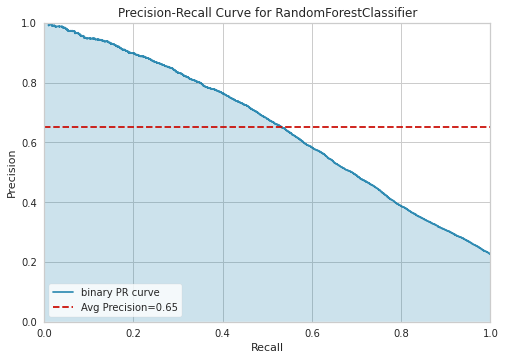

In [21]:
pr_plot(rf_model, rf_data)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


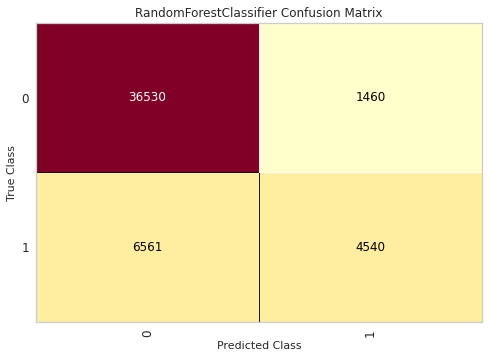

In [22]:
cm_plot(rf_model, rf_data)

I managed to reduce the error gap between test and train without losing AVG percision, but it seems having more data won't help in this case. The variance of training and validation are not that high. So to make the prediction better we need better features and more complex model. Let's include our categorical features. One more thing to consider is rate of FN here is higher than baseline. It's something that we may need some business decision as well, but adding more weights to **class 1**  can help.

In [13]:
ce_bin = ce.BinaryEncoder(cols=cats)

In [14]:
X_train_bin_enc = ce_bin.fit_transform(X_train)
X_test_bin_enc = ce_bin.transform(X_test)

/usr/local/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
rf_data_enc = (X_train_bin_enc, y_train, X_test_bin_enc, y_test)

In [12]:
X_train_bin_enc.shape

(196364, 105)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


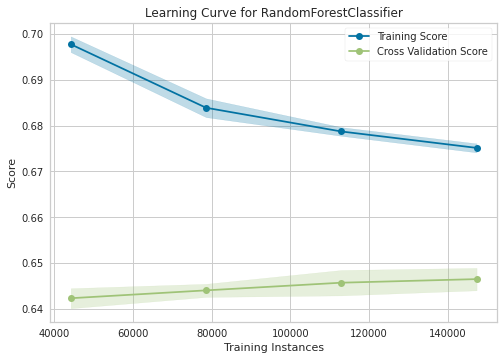

CPU times: user 510 ms, sys: 690 ms, total: 1.2 s
Wall time: 3min 39s


In [15]:
%%time
rf_model = RandomForestClassifier(random_state=SEED, max_depth=15, min_samples_leaf=10)

lc_plot(rf_model, rf_data_enc, n_jobs=3)

This new features didn't help the model that much, but the trend is + instead of being flat, it means more data now can help us. We can use diffrent encoding as well, But Let's try xgboost for now. Most likely it can reducde the high bias.

#### 3.3- GBM

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


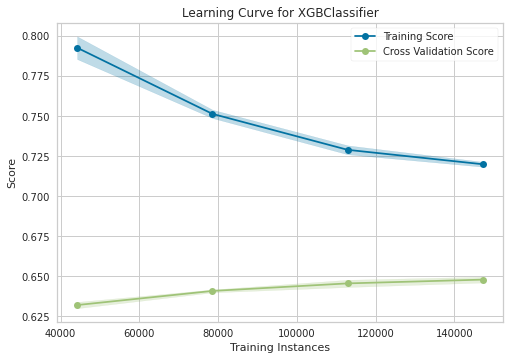

In [62]:
#withhout cat enc
W = (len(X_train) - y_train.sum()) / y_train.sum()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42, scale_pos_weight = W)

data_no_enc = (X_train.drop(cats, axis=1), y_train, X_test.drop(cats, axis=1), y_test)

lc_plot(xgb_model, data_no_enc, n_jobs=3)

In [36]:
%%time
#with cat enc


W = (len(X_train) - y_train.sum()) / y_train.sum()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42, scale_pos_weight = W)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.49 ms


/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


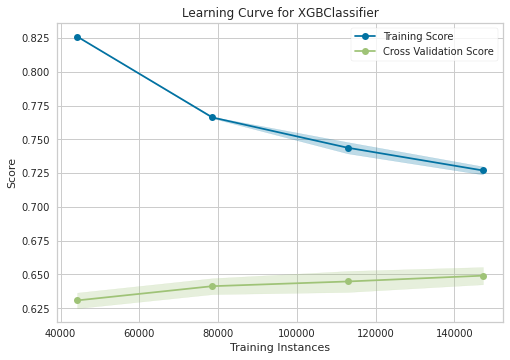

CPU times: user 14min 55s, sys: 3.28 s, total: 14min 59s
Wall time: 7min 39s


In [18]:
lc_plot(xgb_model, rf_data_enc, n_jobs=1)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


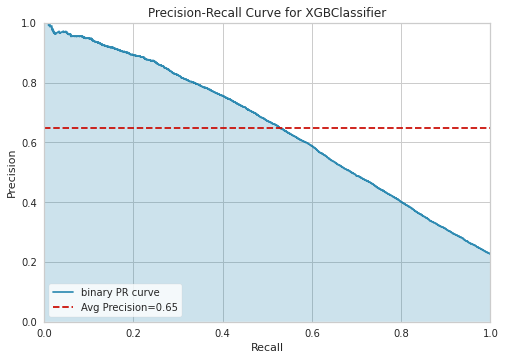

In [37]:
pr_plot(xgb_model, rf_data_enc)

In [41]:
#important features
pd.DataFrame([X_train_bin_enc.columns,xgb_model.feature_importances_]).T.sort_values(1, ascending=False).head(15)

,0,1
5,days_since_last_order,0.15691
4,duration,0.131522
0,cnt,0.106409
7,last_order_failed,0.054319
13,last_order_with_voucher,0.0127696
11,voucher_amount_min,0.011237
58,last_order_payment_id_3,0.0109986
63,last_order_platform_id_3,0.0105504
8,voucher_amount_n,0.00957653
103,payment_id_1779,0.00902528


it seams last_order feartues were helpfull, so it gives more reasones to make city/resturans centirc featuers, and merge them with last_resturant/city.

In [43]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.4220150430122054,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


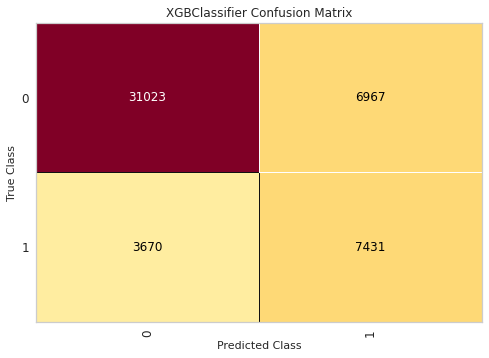

In [42]:
cm_plot(xgb_model, rf_data_enc)

This matrix is not that much helpfull for now, becasue we are using the default threshold point(0.5). It's to keep in mind we can move to diffrent direction with help of Precision and recall plot, and find the threshold that help us in business goal.


### Future works
1. More categorical encoding ways, like bayesian encoders.
2. use try models that are better in handleing categorical features(EX. CatBoost)
3. Hyperparameter optimization
4. Clustering based faetuers
5. Use diffrent methods for handleing imbalanced data(sampleing methods and make artificial data)
